# Regression Discontinuity Design

## Prepare Notebook

In [30]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy.special import expit

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
seed: int = 12282020
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Data Generation

[Text(0.5, 1.0, 'Treatment Effect'), Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

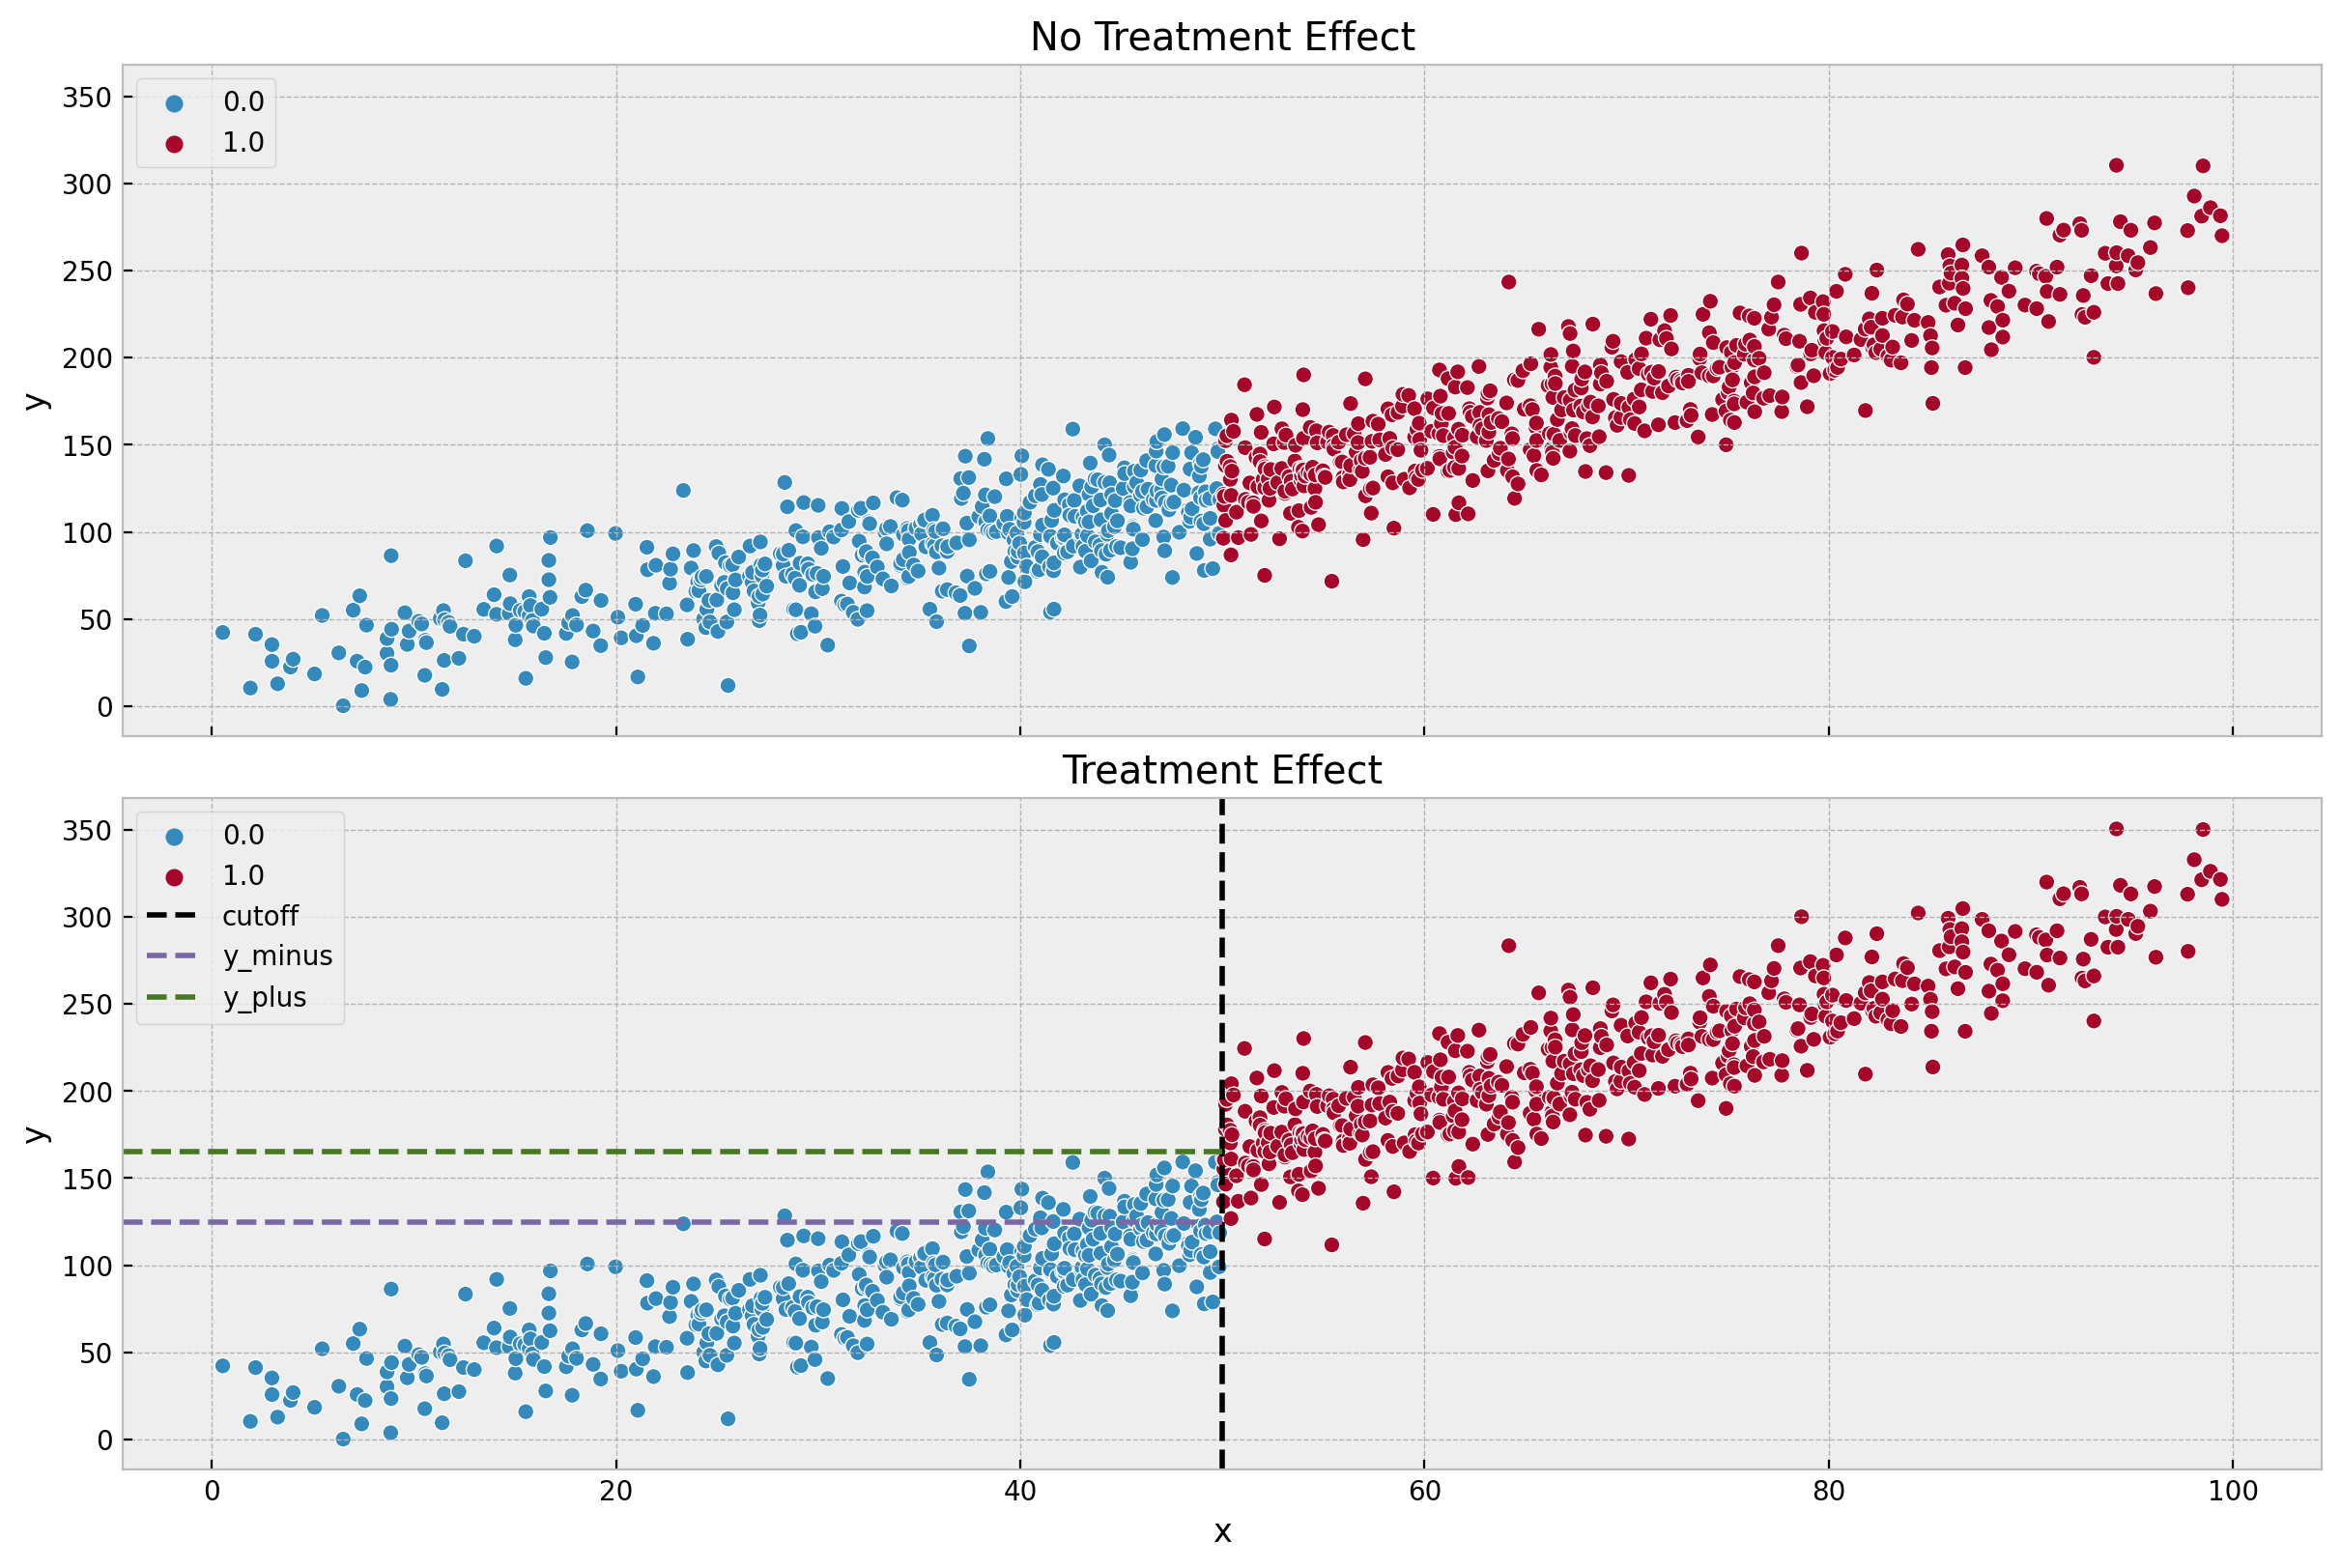

In [58]:
n = 1_000
c = 50
delta = 40

x = rng.normal(loc=c, scale=25, size=n)

d = (x > c).astype(float)

intercept = 25
slope = 1.5
quadratic = 0.01

y0 = (
    intercept
    + slope * x
    + quadratic * x**2
    + 0 * d
    + rng.normal(loc=0, scale=20, size=n)
)
y = y0 + delta * d

data = pd.DataFrame(data={"x": x, "d": d, "y0": y0, "y": y})
mask = "0 < x < 100 and 0 < y0 and 0 < y"
data = data.query(expr=mask).sort_values(by="x").reset_index(drop=True)

y_minus = intercept + slope * c + quadratic * c**2
y_plus = y_minus + delta

fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 8), layout="constrained"
)
sns.scatterplot(data=data, x="x", y="y0", hue="d", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set(title="No Treatment Effect", xlabel="x", ylabel="y")
sns.scatterplot(data=data, x="x", y="y", hue="d", ax=ax[1])
ax[1].axvline(x=c, color="black", linestyle="--", label="cutoff")
ax[1].axhline(
    y=y_minus,
    xmax=0.5,
    color="C2",
    linestyle="--",
    label="y_minus",
)
ax[1].axhline(
    y=y_plus,
    xmax=0.5,
    color="C3",
    linestyle="--",
    label="y_plus",
)
ax[1].legend(loc="upper left")
ax[1].set(title="Treatment Effect", xlabel="x", ylabel="y")


In [59]:
delta_true = y_plus - y_minus
delta_true

40.0

In [60]:
data["x_c"] = data["x"] - c

obs_idx = data.index.to_numpy()
x_c = data["x_c"].to_numpy()
d = data["d"].to_numpy()
y = data["y"].to_numpy()

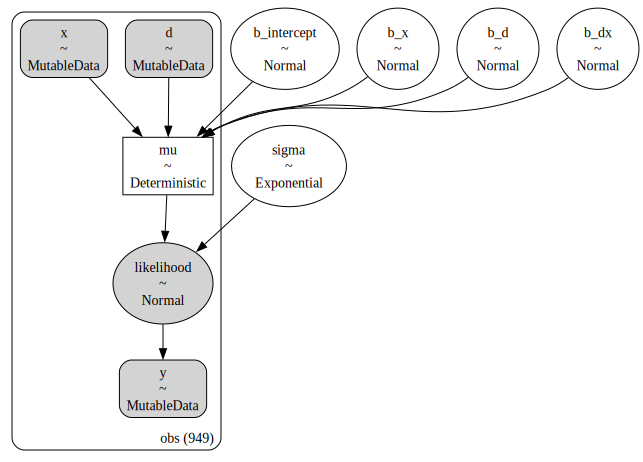

In [68]:
with pm.Model(coords={"obs": obs_idx}) as gaussian_model:
    # --- Data Containers ---
    x_ = pm.MutableData(name="x", value=x_c, dims="obs")
    d_ = pm.MutableData(name="d", value=d, dims="obs")
    y_ = pm.MutableData(name="y", value=y, dims="obs")
    # --- Priors ---
    b_intercept = pm.Normal(name="b_intercept", mu=0, sigma=10)
    b_x = pm.Normal(name="b_x", mu=0, sigma=10)
    b_d = pm.Normal(name="b_d", mu=0, sigma=10)
    b_dx = pm.Normal(name="b_dx", mu=0, sigma=10)
    sigma = pm.Exponential(name="sigma", lam=1 / 20)
    # --- Deterministic Variables ---
    mu = pm.Deterministic(
        name="mu",
        var=b_intercept + b_x * x_ + b_d * d_ + b_dx * d_ * x_,
        dims="obs",
    )
    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=y_,
        dims="obs",
    )

pm.model_to_graphviz(model=gaussian_model)

In [69]:
with gaussian_model:
    gaussian_idata = pm.sample(draws=6_000, chains=4, nuts_sampler="numpyro")
    gaussian_posterior_predictive = pm.sample_posterior_predictive(trace=gaussian_idata)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.714758
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time =  0:00:05.073045
Transforming variables...


In [70]:
gaussian_idata["sample_stats"]["diverging"].sum().item()

0

In [71]:
az.summary(
    data=gaussian_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma"],
)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_intercept,119.602,1.659,116.628,122.893,0.019,0.014,7316.0,9679.0,1.0
b_x,1.973,0.079,1.823,2.120,0.001,0.001,7368.0,9998.0,1.0
b_d,41.712,2.293,37.346,45.965,0.023,0.016,10122.0,12716.0,1.0
b_dx,1.005,0.108,0.804,1.209,0.001,0.001,9458.0,11937.0,1.0
sigma,20.787,0.477,19.897,21.699,0.004,0.003,17647.0,14901.0,1.0


Text(0.5, 0.98, 'Linear Regression Model - Trace')

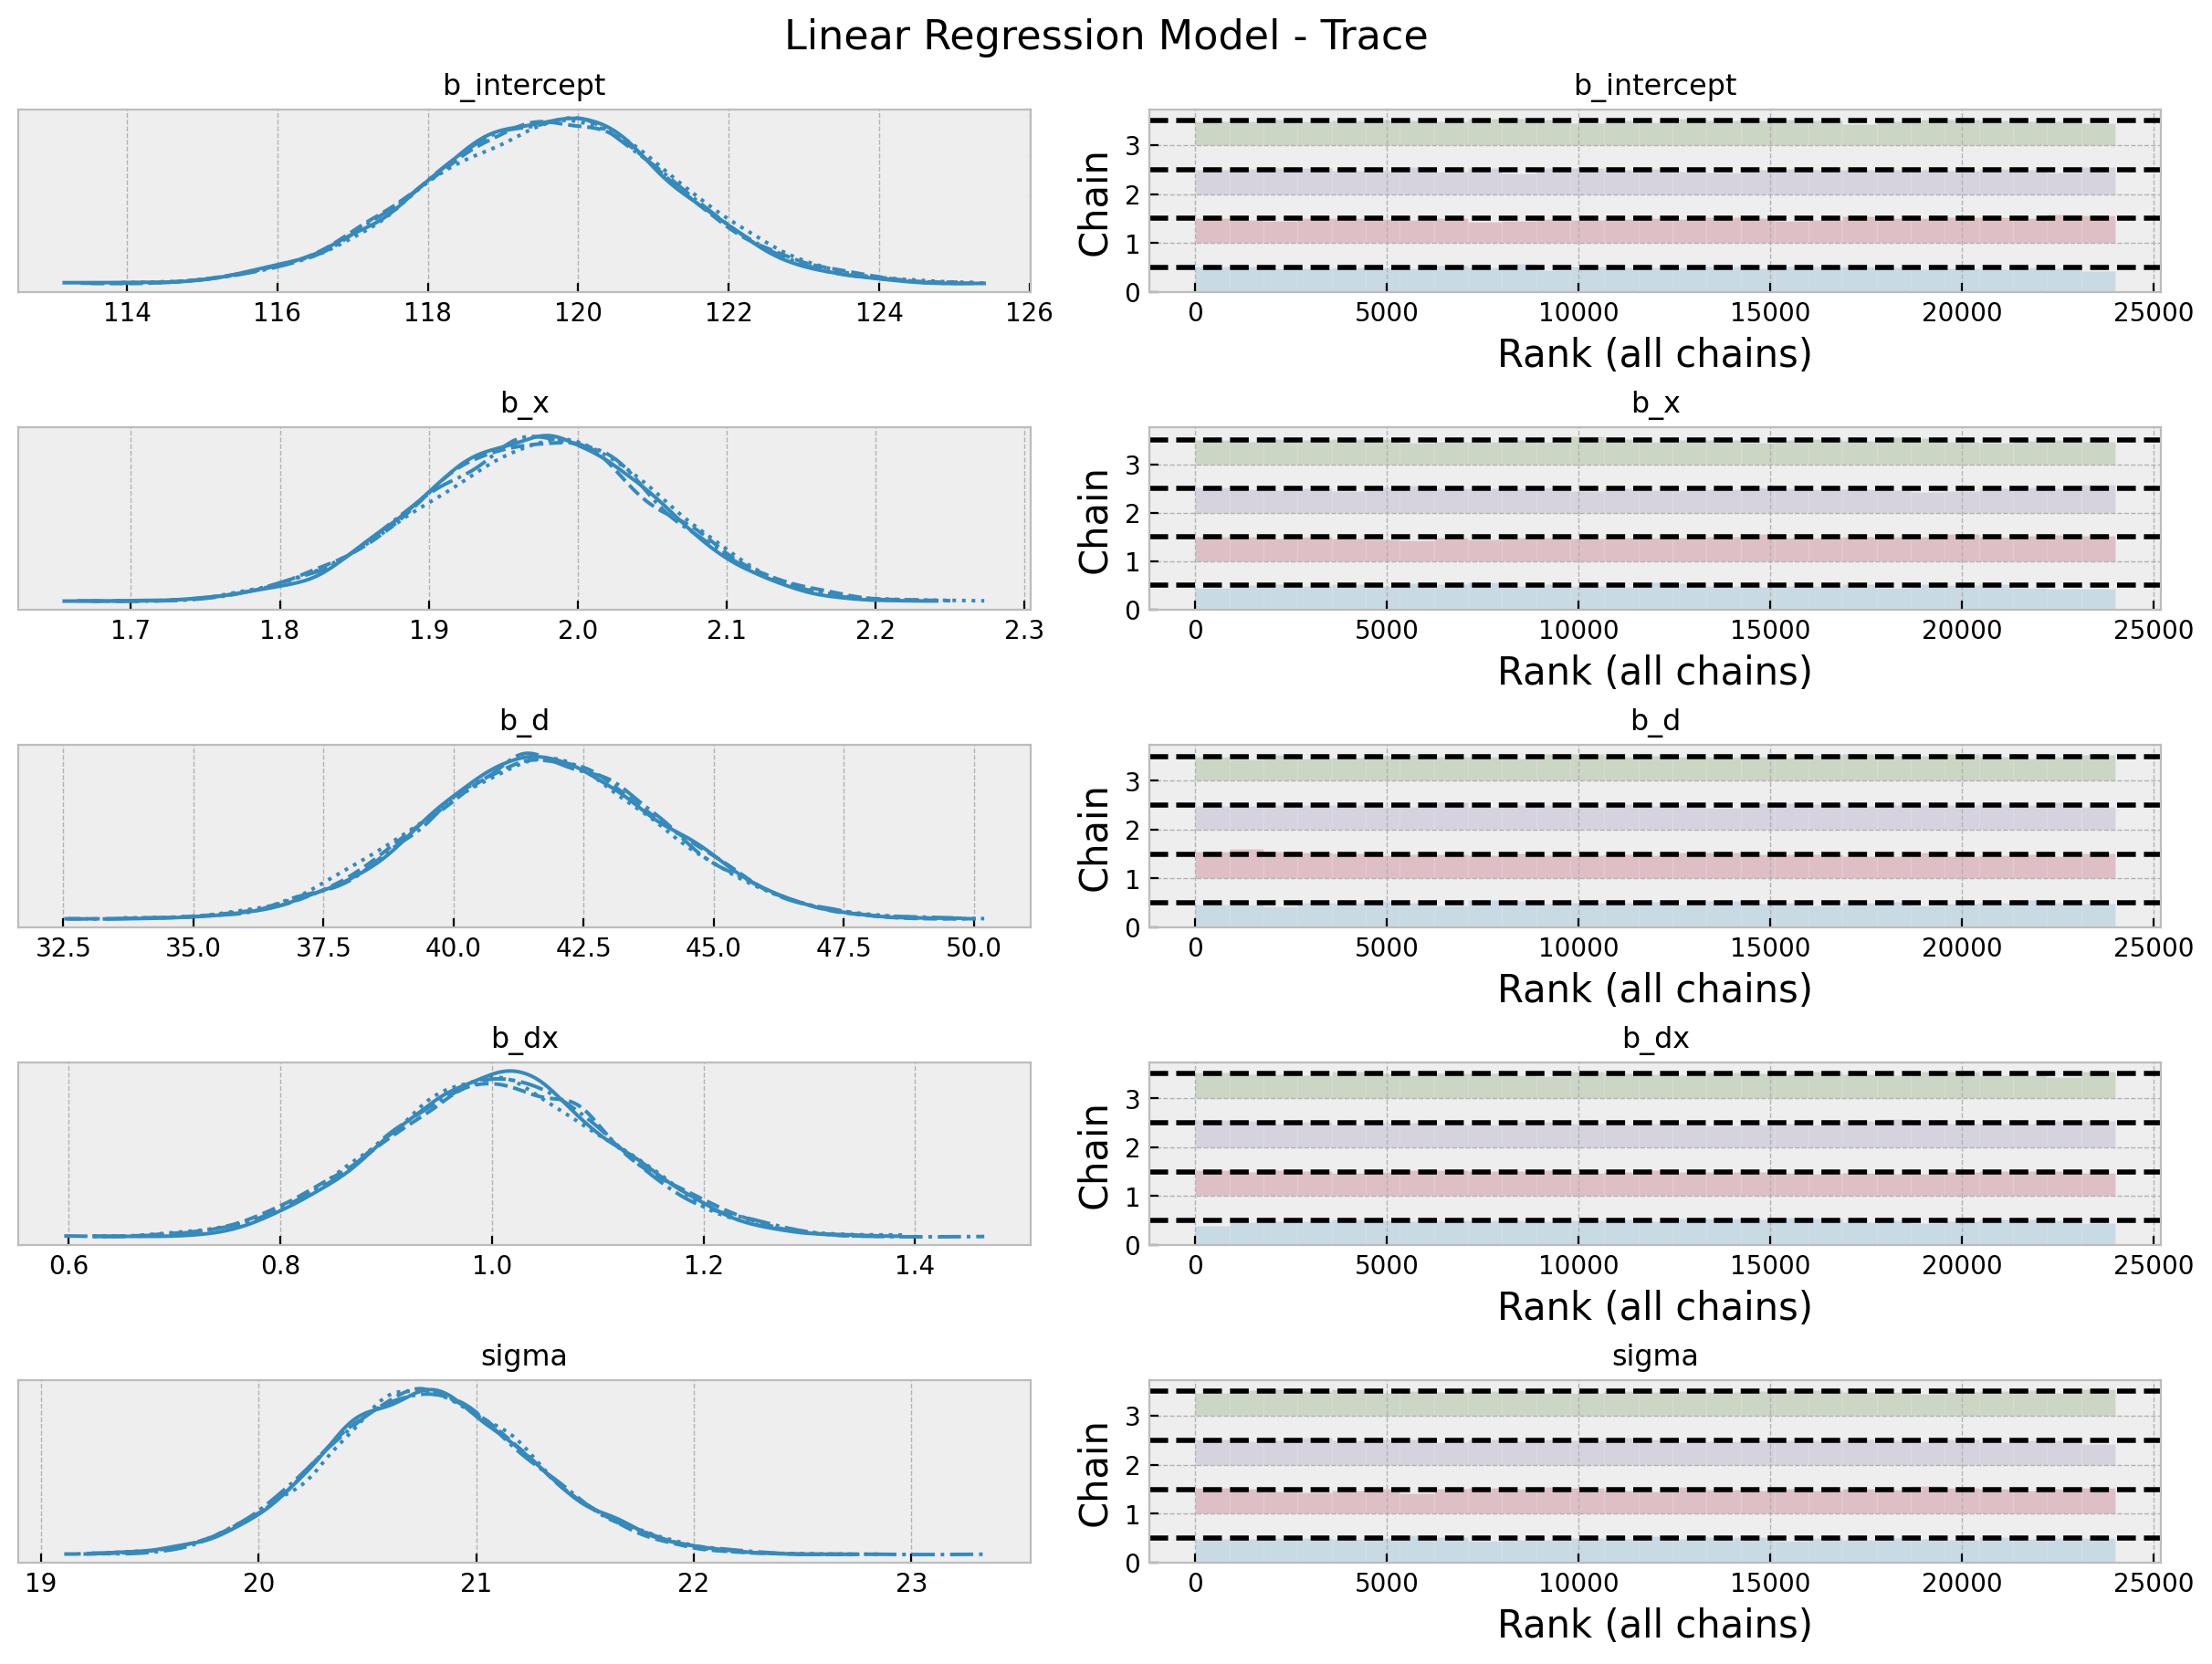

In [72]:
axes = az.plot_trace(
    data=gaussian_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Regression Model - Trace", fontsize=16)

[Text(0.5, 1.0, 'Linear Regression Model')]

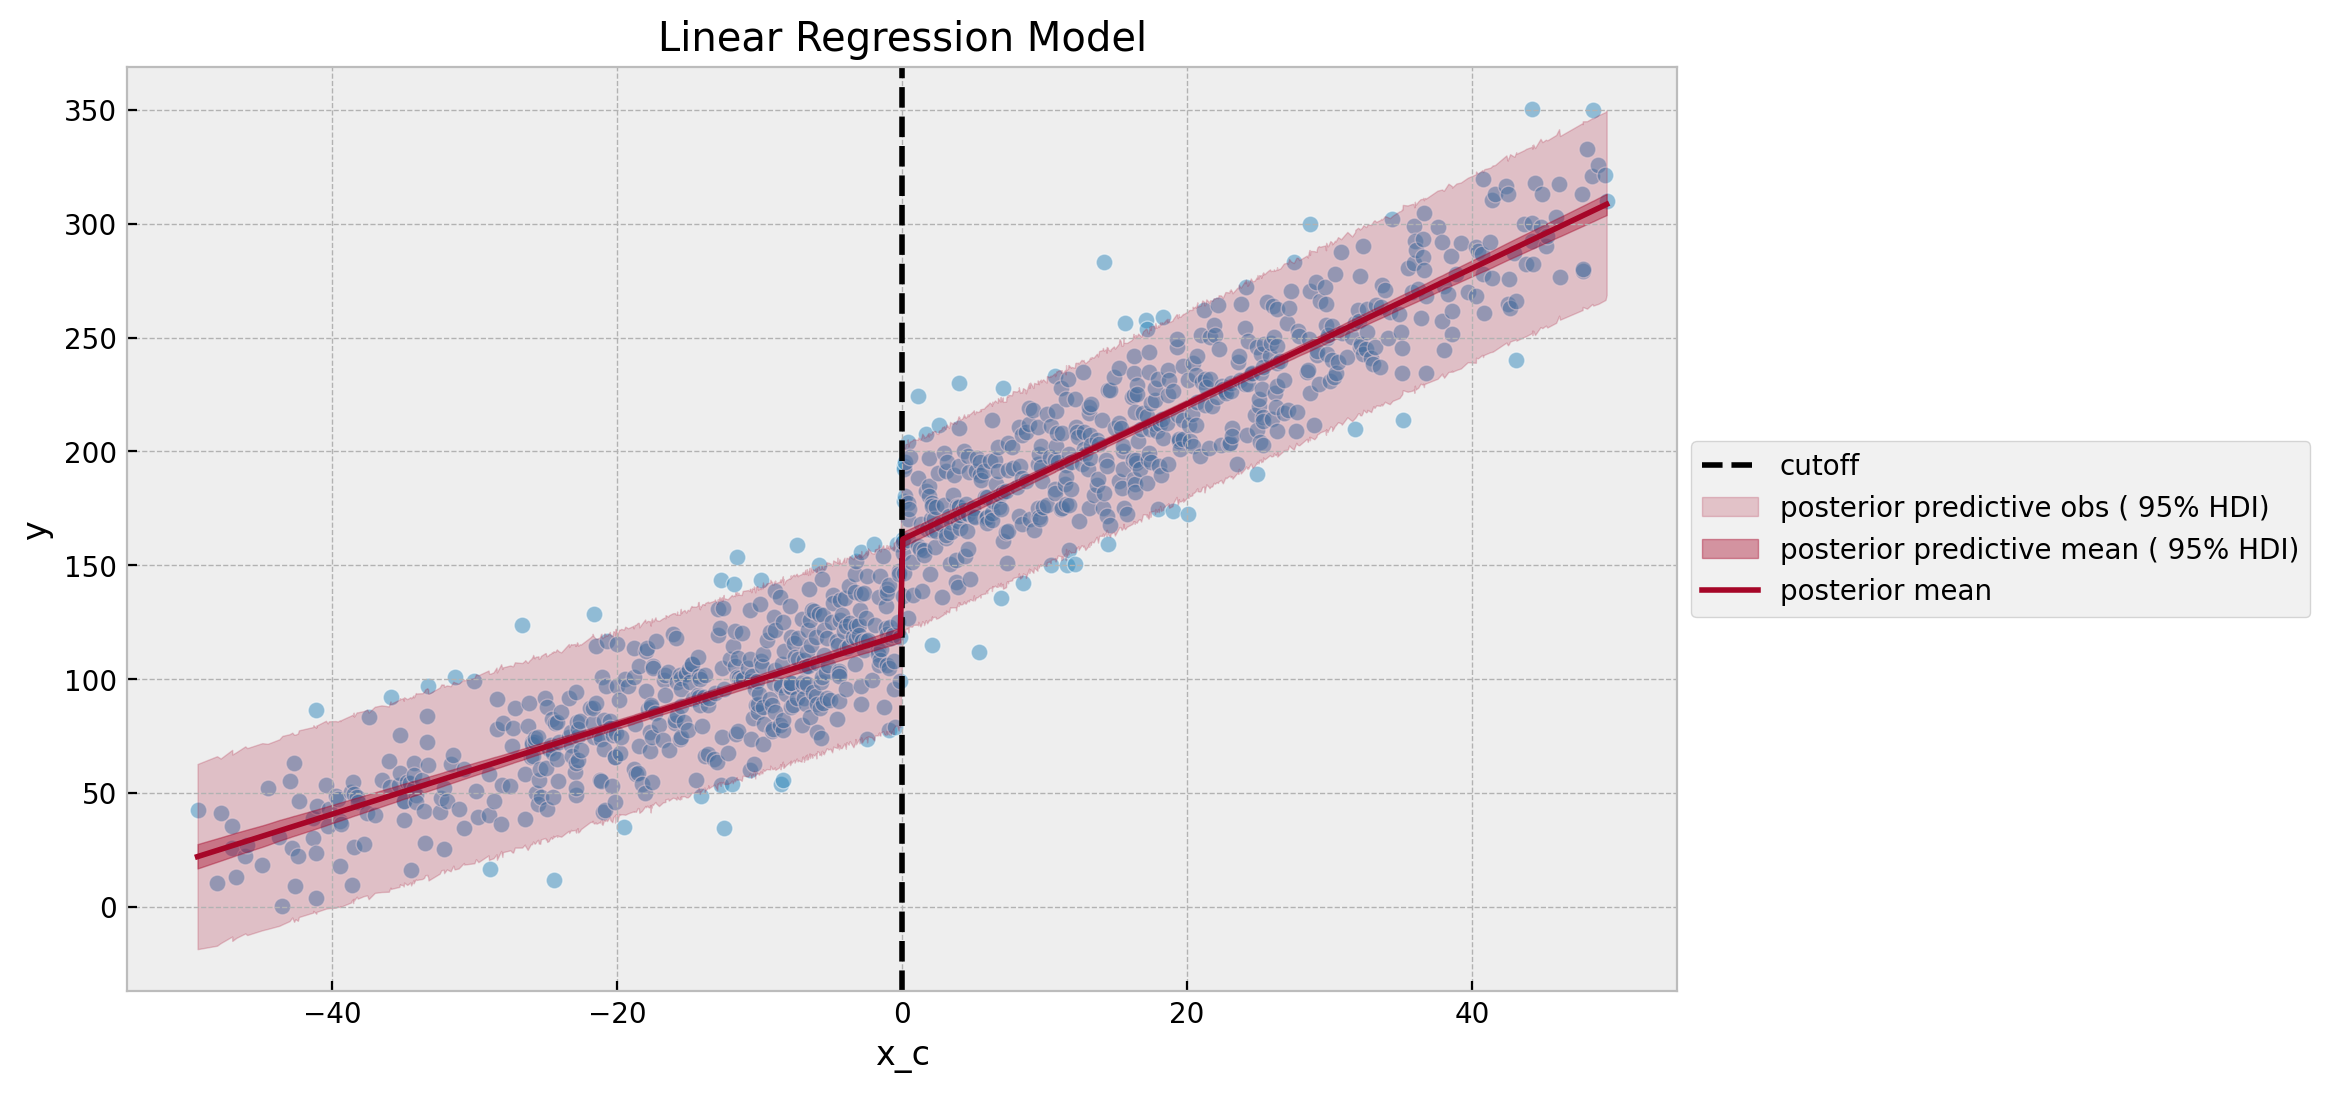

In [74]:
alpha = 0.05

fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gaussian_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gaussian_idata["posterior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
sns.lineplot(
    x=x_c,
    y=gaussian_idata["posterior"]["mu"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior mean",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Linear Regression Model")


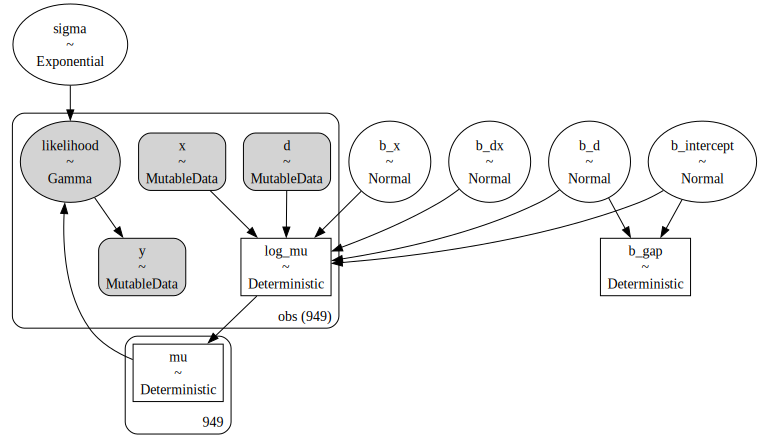

In [75]:
with pm.Model(coords={"obs": obs_idx}) as gamma_model:
    # --- Data Containers ---
    x_ = pm.MutableData(name="x", value=x_c, dims="obs")
    d_ = pm.MutableData(name="d", value=d, dims="obs")
    y_ = pm.MutableData(name="y", value=y, dims="obs")
    # --- Priors ---
    b_intercept = pm.Normal(name="b_intercept", mu=0, sigma=10)
    b_x = pm.Normal(name="b_x", mu=0, sigma=10)
    b_d = pm.Normal(name="b_d", mu=0, sigma=10)
    b_dx = pm.Normal(name="b_dx", mu=0, sigma=10)
    sigma = pm.Exponential(name="sigma", lam=1 / 20)
    # --- Deterministic Variables ---
    log_mu = pm.Deterministic(
        name="log_mu",
        var=b_intercept + b_x * x_ + b_d * d_ + b_dx * d_ * x_,
        dims="obs",
    )
    mu = pm.Deterministic(name="mu", var=pm.math.exp(log_mu))
    pm.Deterministic(
        name="b_gap", var=pm.math.exp(b_intercept) * (pm.math.exp(b_d) - 1)
    )
    # --- Likelihood ---
    pm.Gamma(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=y_,
        dims="obs",
    )

pm.model_to_graphviz(model=gamma_model)

In [77]:
with gamma_model:
    gamma_idata = pm.sample(draws=6_000, chains=4, nuts_sampler="numpyro")
    gamma_posterior_predictive = pm.sample_posterior_predictive(trace=gamma_idata)

In [78]:
gamma_idata["sample_stats"]["diverging"].sum().item()

0

In [79]:
az.summary(
    data=gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_intercept,4.866,0.016,4.837,4.897,0.000,0.000,6532.0,7942.0,1.0
b_x,0.027,0.001,0.025,0.029,0.000,0.000,9377.0,11699.0,1.0
b_d,0.259,0.018,0.224,0.292,0.000,0.000,6572.0,7864.0,1.0
b_dx,-0.014,0.001,-0.016,-0.012,0.000,0.000,10688.0,13368.0,1.0
sigma,21.596,0.517,20.662,22.599,0.006,0.004,7718.0,10185.0,1.0
b_gap,38.351,2.535,33.575,43.116,0.031,0.022,6904.0,8836.0,1.0


Text(0.5, 0.98, 'Gamma Regression Model - Trace')

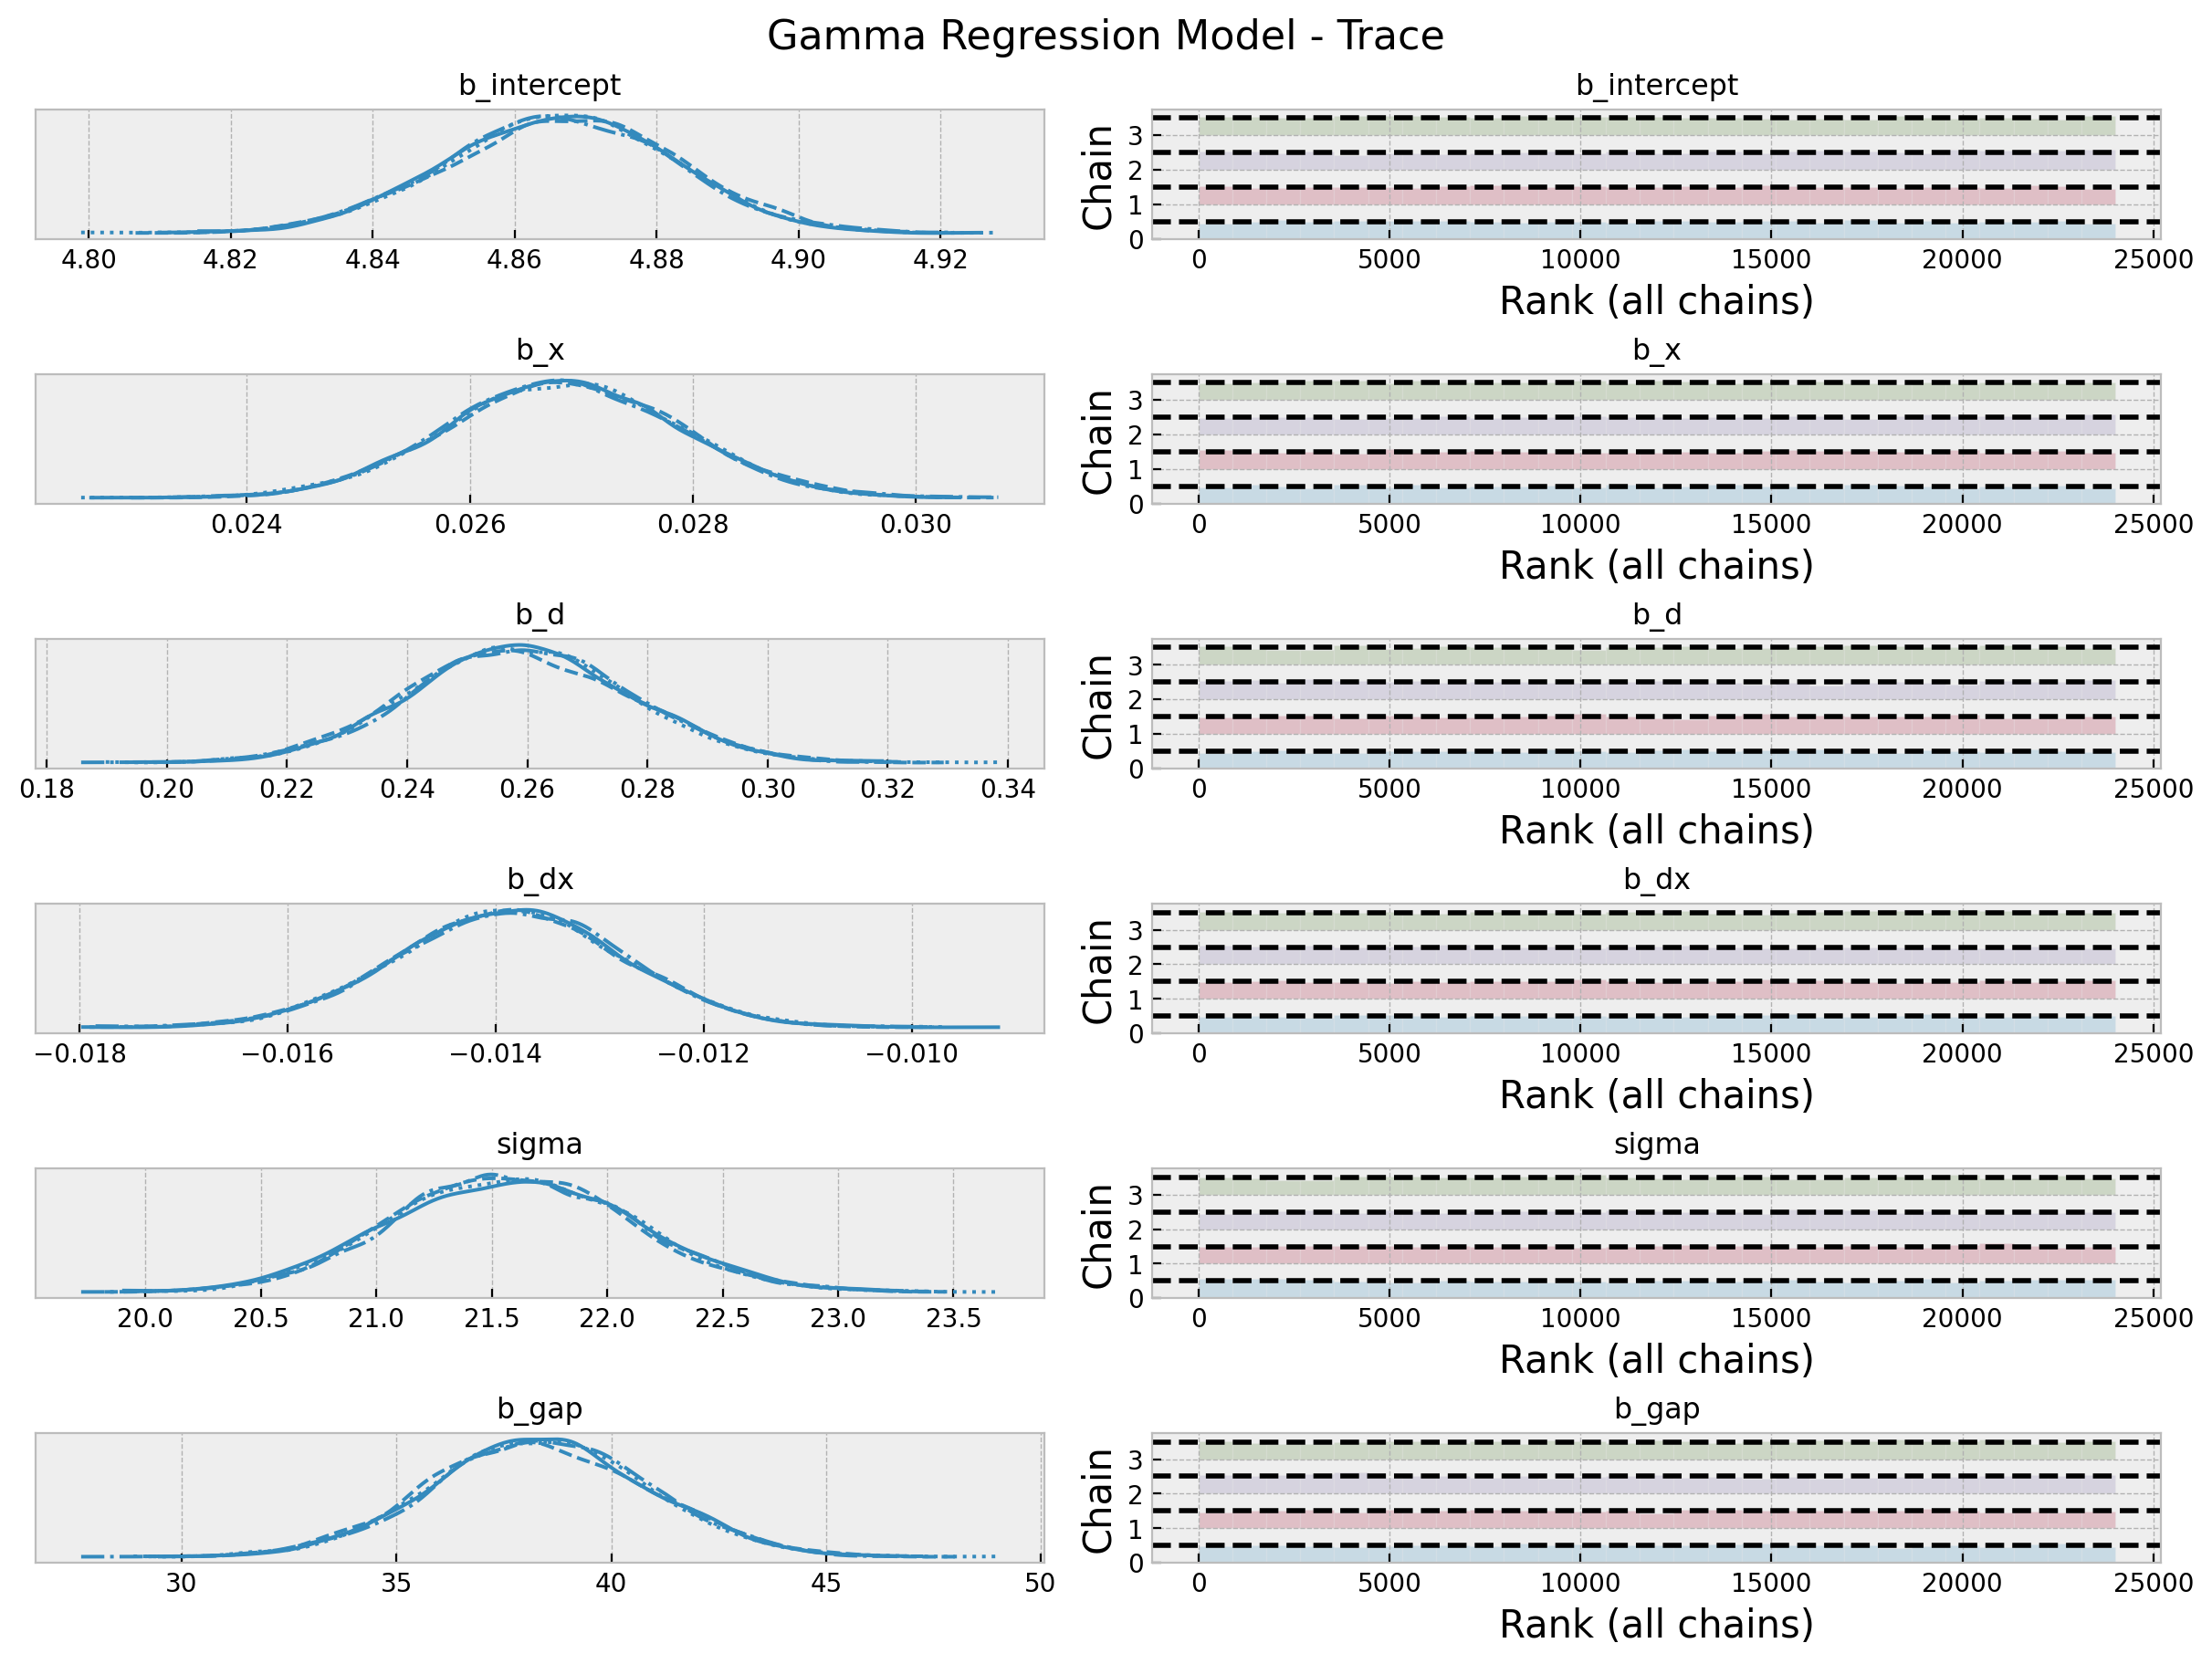

In [80]:
axes = az.plot_trace(
    data=gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma Regression Model - Trace", fontsize=16)

[Text(0.5, 1.0, 'Gamma Regression Model')]

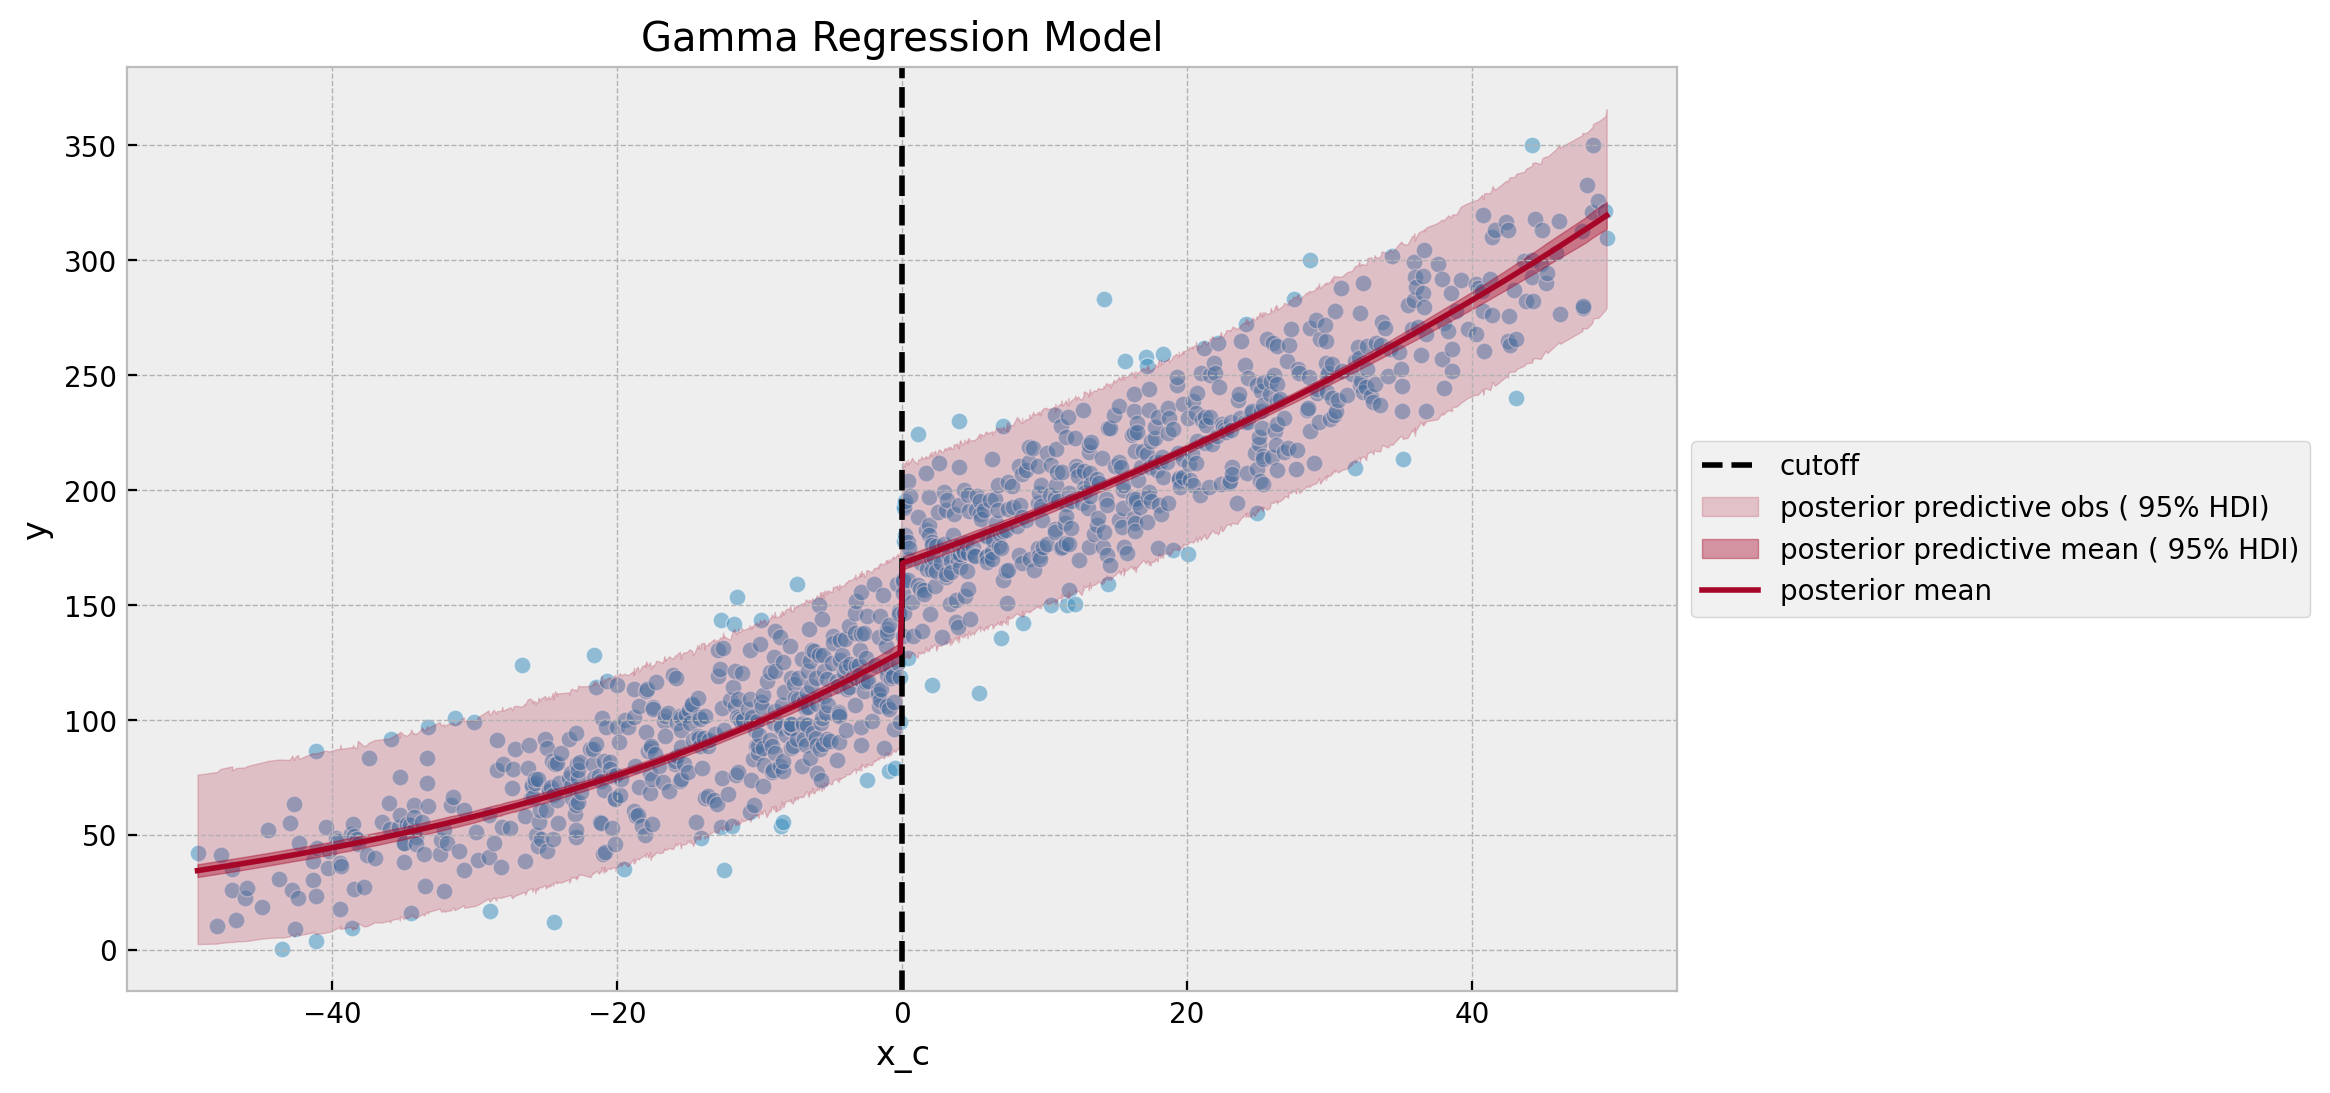

In [82]:
alpha = 0.05

fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gamma_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gamma_idata["posterior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
sns.lineplot(
    x=x_c,
    y=gamma_idata["posterior"]["mu"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior mean",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Gamma Regression Model")


[Text(0.5, 1.0, 'Gamma Regression Model')]

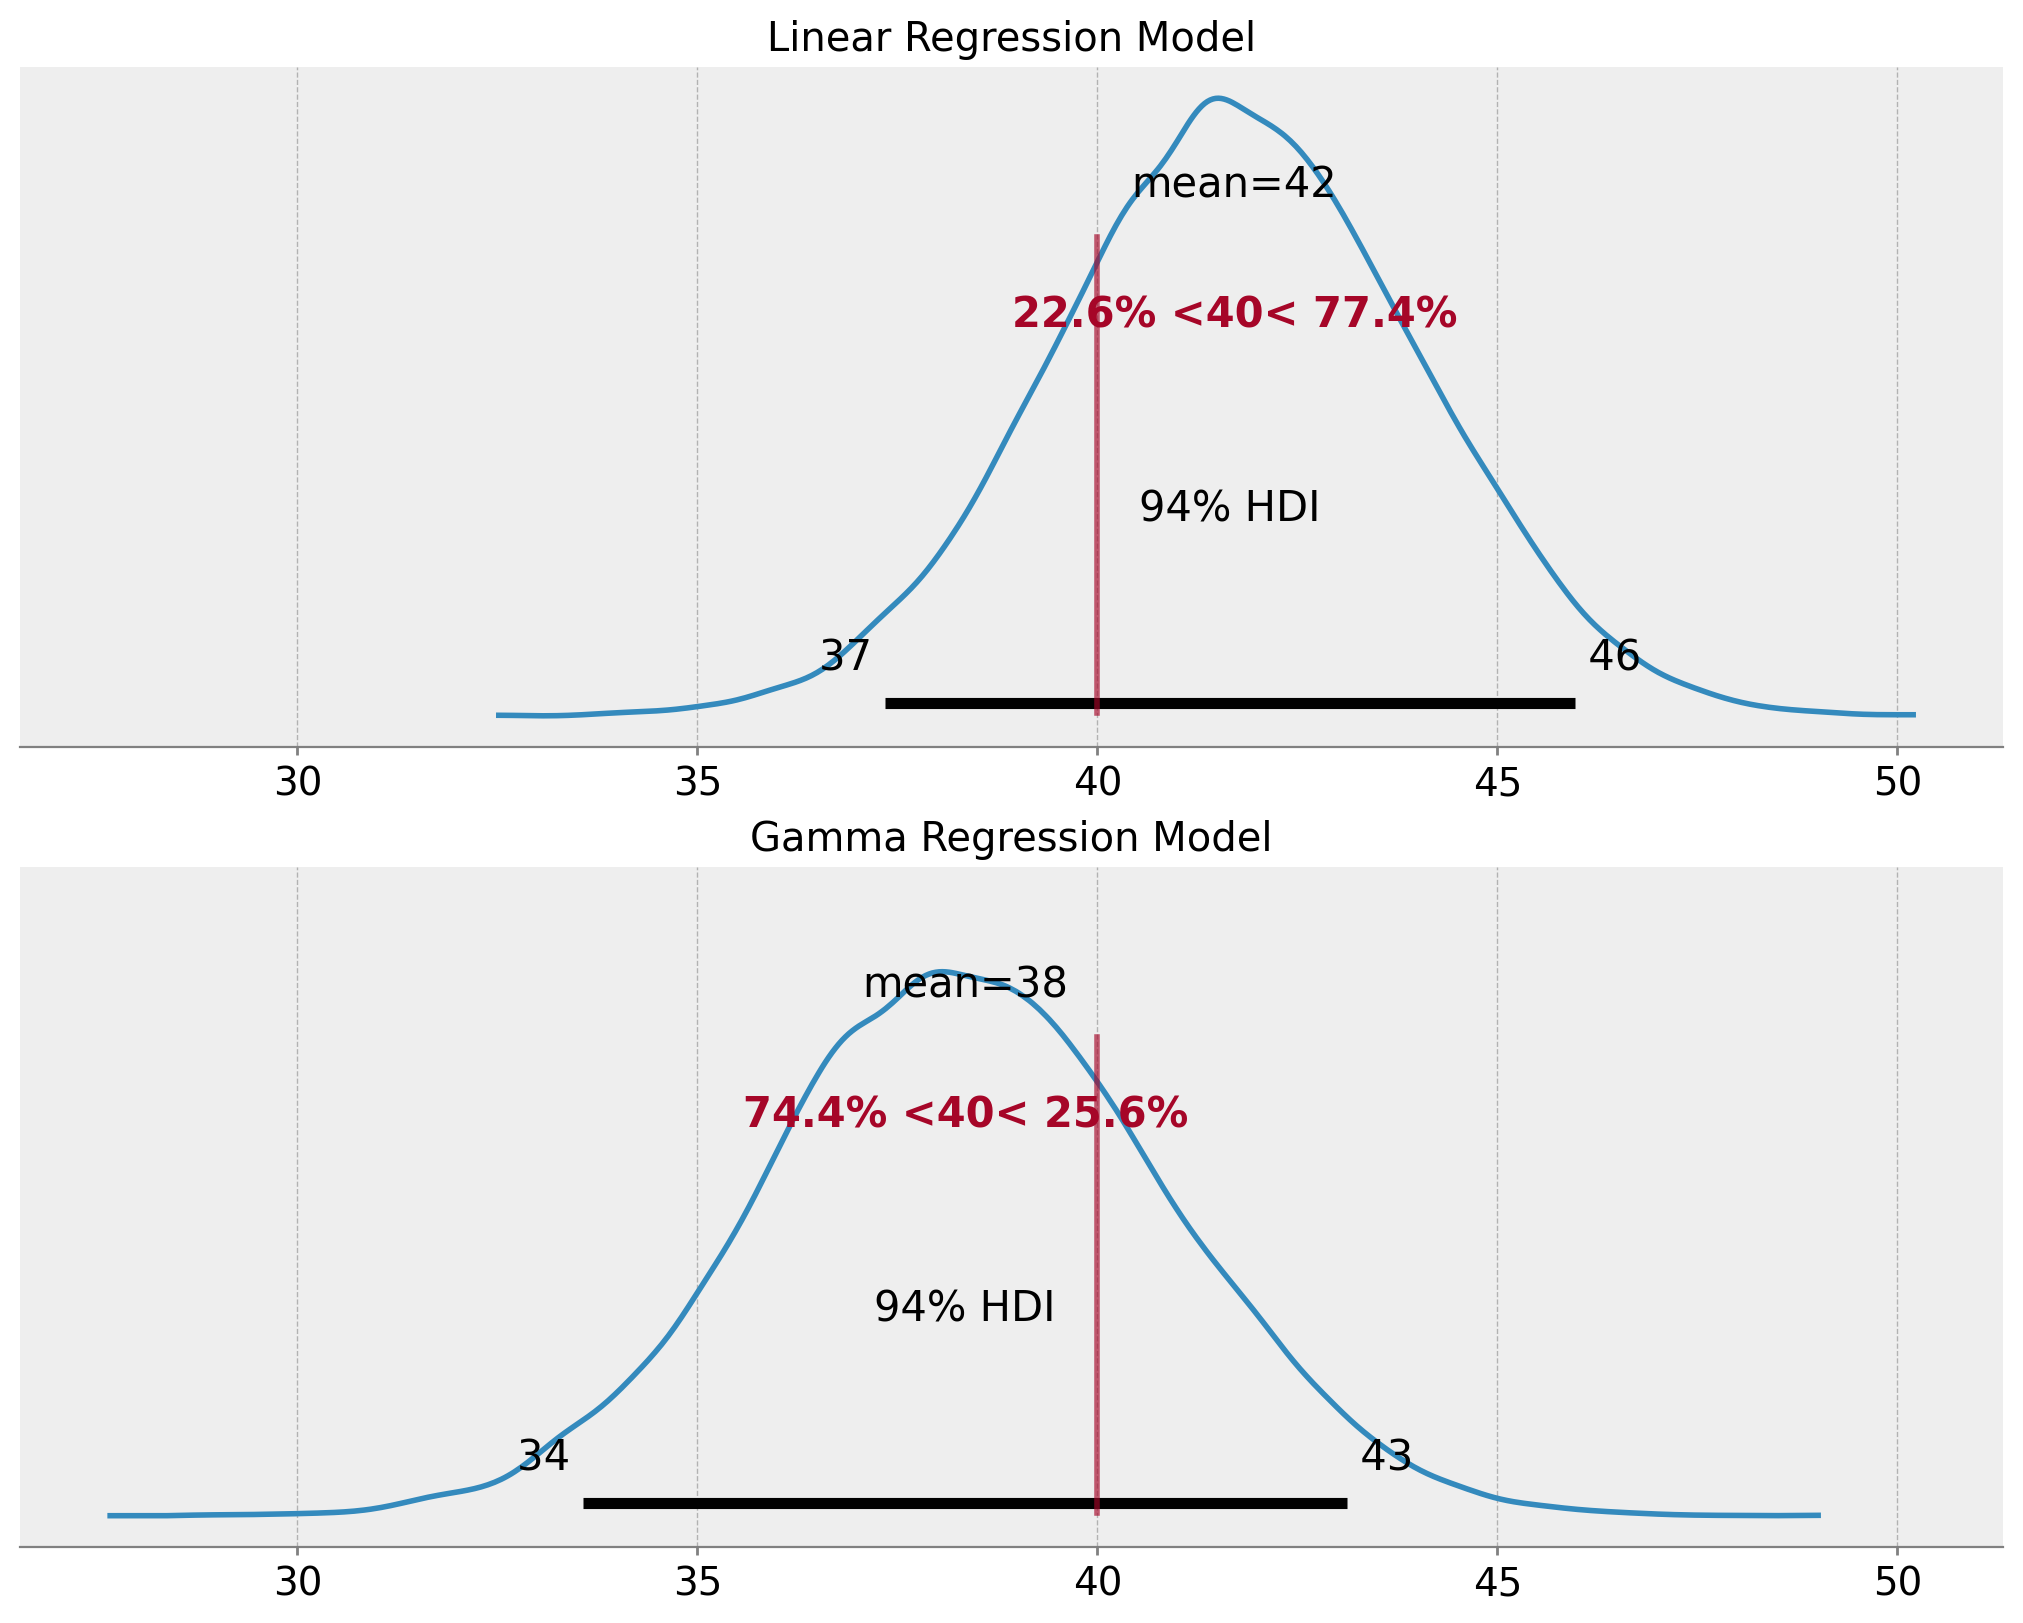

In [92]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 8), layout="constrained"
)
az.plot_posterior(data=gaussian_idata, var_names=["b_d"], ref_val=delta_true, ax=ax[0])
ax[0].set(title="Linear Regression Model")
az.plot_posterior(data=gamma_idata, var_names=["b_gap"], ref_val=delta_true, ax=ax[1])
ax[1].set(title="Gamma Regression Model")
